In [1]:
from __future__ import print_function, division
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#define size to which images are to be resized
IMAGE_SIZE = [224, 224] # feel free to change depending on dataset

# training config:
epochs = 95
batch_size = 24


#define paths
covid_path = '/content/drive/MyDrive/Data/Covid'
noncovid_path = '/content/drive/MyDrive/Data/NonCovid'

# Use glob to grab images from path .jpg or jpeg
covid_files = glob(covid_path + '/*')
noncovid_files = glob(noncovid_path + '/*')

In [4]:
# Preparing Labels
covid_labels = []
noncovid_labels = []

covid_images=[]
noncovid_images=[]

import cv2 

for i in range(len(covid_files)):
  image = cv2.imread(covid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  covid_images.append(image)
  covid_labels.append('COVID')
for i in range(len(noncovid_files)):
  image = cv2.imread(noncovid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  noncovid_images.append(image)
  noncovid_labels.append('NonCOVID')

In [5]:
# normalize to interval of [0,1]
covid_images = np.array(covid_images) / 255
noncovid_images = np.array(noncovid_images) / 255

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

# split into training and testing
covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(
    covid_images, covid_labels, test_size=0.3)
noncovid_x_train, noncovid_x_test, noncovid_y_train, noncovid_y_test = train_test_split(
    noncovid_images, noncovid_labels, test_size=0.3)


X_train = np.concatenate((noncovid_x_train, covid_x_train), axis=0)
X_test = np.concatenate((noncovid_x_test, covid_x_test), axis=0)
y_train = np.concatenate((noncovid_y_train, covid_y_train), axis=0)
y_test = np.concatenate((noncovid_y_test, covid_y_test), axis=0)

# make labels into categories - either 0 or 1
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

In [7]:
res = ResNet50(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = res.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=res.input, outputs=outputs)

for layer in res.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

94781440/94765736 [==============================] - 4s 0us/step


In [8]:
history = model.fit(train_aug.flow(X_train, y_train, batch_size=24),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / 24,
                    steps_per_epoch=len(X_train) / 24,
                    epochs=95)

Epoch 1/95
27/27 [==============================] - 26s 472ms/step - loss: 2.4135 - accuracy: 0.5022 - val_loss: 0.6969 - val_accuracy: 0.5312
Epoch 2/95
27/27 [==============================] - 11s 398ms/step - loss: 1.1617 - accuracy: 0.5351 - val_loss: 0.7454 - val_accuracy: 0.5312
Epoch 3/95
27/27 [==============================] - 12s 424ms/step - loss: 0.9406 - accuracy: 0.5710 - val_loss: 1.0915 - val_accuracy: 0.5312
Epoch 4/95
27/27 [==============================] - 12s 421ms/step - loss: 1.2522 - accuracy: 0.5291 - val_loss: 0.6133 - val_accuracy: 0.6979
Epoch 5/95
27/27 [==============================] - 11s 394ms/step - loss: 1.4794 - accuracy: 0.5725 - val_loss: 0.7226 - val_accuracy: 0.5208
Epoch 6/95
27/27 [==============================] - 12s 416ms/step - loss: 1.0681 - accuracy: 0.5516 - val_loss: 0.6018 - val_accuracy: 0.6389
Epoch 7/95
27/27 [==============================] - 12s 416ms/step - loss: 1.1117 - accuracy: 0.5501 - val_loss: 1.0218 - val_accuracy: 0.5104

In [9]:
model.save('resnet_chest.h5')
model.save_weights('resnetweights_chest.hdf5')

In [10]:
model = load_model('resnet_chest.h5')

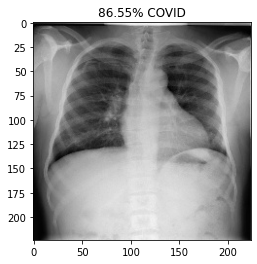

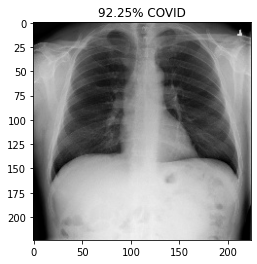

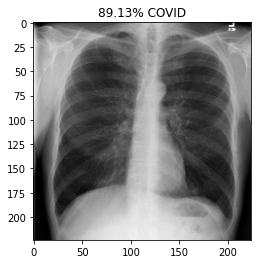

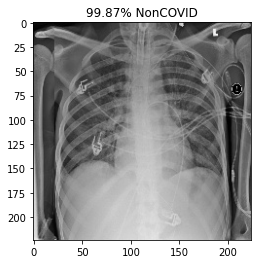

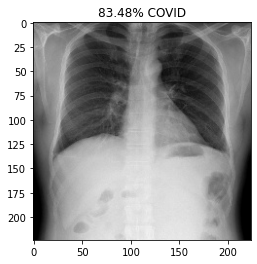

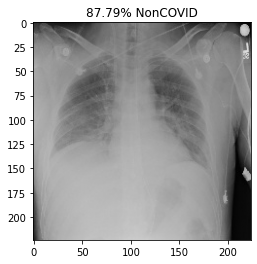

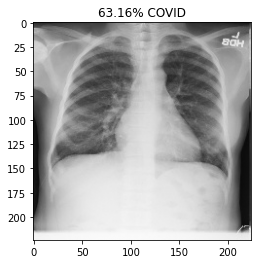

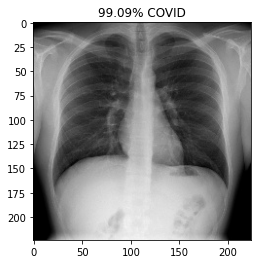

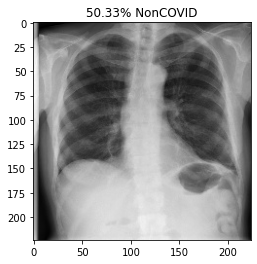

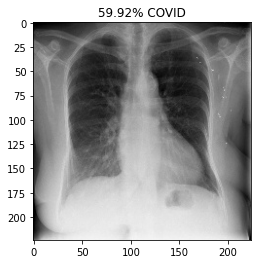

In [11]:
y_pred = model.predict(X_test, batch_size=batch_size)
#Visulaizing First 10 predictions
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% COVID')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% NonCOVID')
  plt.imshow(X_test[index])
  plt.show()

In [12]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

Confusion Matrix without Normalization


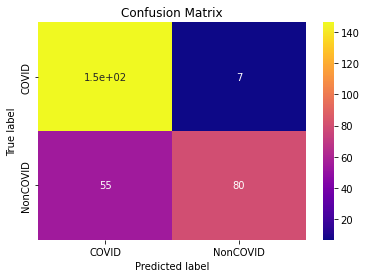

Confusion Matrix with Normalized Values


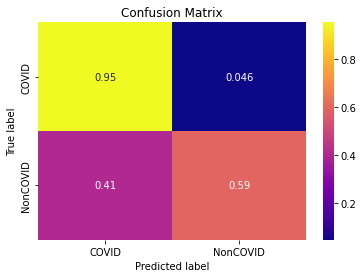

In [13]:
def plot_confusion_matrix(normalize):
  classes = ['COVID','NonCOVID']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')


In [14]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.73      0.95      0.82       153
           1       0.92      0.59      0.72       135

    accuracy                           0.78       288
   macro avg       0.82      0.77      0.77       288
weighted avg       0.82      0.78      0.78       288



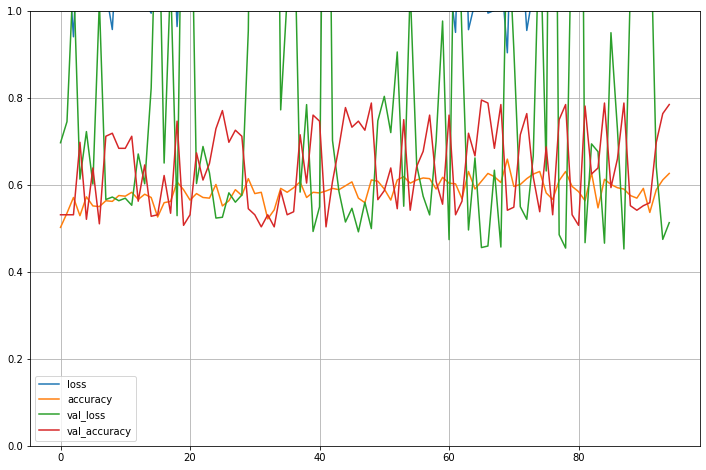

In [15]:
pd.DataFrame(history.history).plot(figsize=(12, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()